## Data

### Input Data (OpenStreetMap)

In [18]:
import geopandas as gpd
from shapely import wkt

# Load the dataset
amenities = gpd.read_file('all_data.csv')

# Convert the geometry column from strings to actual geometries
amenities['geometry'] = amenities['geometry'].apply(wkt.loads)

# Convert to a Geopandas GeoDataFrame
amenities = gpd.GeoDataFrame(amenities, geometry='geometry')

# Function that checks if geometry is a point and converts it for the hexagon ID creation
def geometry_to_hexagon(geometry):
    if geometry.geom_type == 'Point':
        return lat_lng_to_hexagon(geometry.y, geometry.x, hex_resolution)
    else:
        return None  # Voor polygonen geen hex_id genereren

# HEXAGON CREATION
import h3
# Function to convert latitude and longitude to a hexagon ID
def lat_lng_to_hexagon(lat, lng, resolution):
    return h3.latlng_to_cell(lat, lng, resolution)

# Hexagon Size
hex_resolution = 12

# Check if the geometry is a point and apply the hexagon transformation only to points
def geometry_to_hexagon(geometry):
    if geometry.geom_type == 'Point':
        return lat_lng_to_hexagon(geometry.y, geometry.x, hex_resolution)
    else:
        return None  # Voor polygonen geen hex_id genereren

# Apply to the geometry column
amenities['hex_id'] = amenities['geometry'].apply(geometry_to_hexagon)

# Filter rows with a valid hex_id (i.e., without None)
amenities_with_hex = amenities[amenities['hex_id'].notnull()]

# Group by hex_id and type of amenity, and count the number of amenities
hexagon_amenity_counts = amenities_with_hex.groupby(['hex_id', 'type']).size().reset_index(name='amenity_count')

# Save or display the result
hexagon_amenity_counts.to_csv('osm_amenities_hexagons_per_amenity.csv', index=False)

In [19]:
display(hexagon_amenity_counts)

hexagon_amenity_counts.info()

,hex_id,type,amenity_count
0,8c2a100002921ff,stop,1
1,8c2a100002927ff,crossing,1
2,8c2a100002987ff,stop,1
3,8c2a1000029e9ff,stop,1
4,8c2a100002c4dff,ferry_terminal,1
...,...,...,...
349360,8c2a107aed713ff,crossing,1
349361,8c2a107aed717ff,crossing,1
349362,8c2a107aed717ff,traffic_signals,1
349363,8c2a107aed737ff,bar,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349365 entries, 0 to 349364
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   hex_id         349365 non-null  object
 1   type           349365 non-null  object
 2   amenity_count  349365 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.0+ MB


### Output Data (Noise Complaints)

In [20]:
import pandas as pd

Noise_Complaint_Data = pd.read_csv('Preprocessed_output_data.csv')


# HEXAGON CREATION
import h3

# Hexagon Size
hex_resolution = 10

# New column 'hex_id' with the hexagon ID for each (latitude, longitude) pair
Noise_Complaint_Data['hex_id'] = Noise_Complaint_Data.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], hex_resolution), axis=1)

# Group by hexagon ID and 'combined complaint type descriptor' and count complaints in each hexagon
hex_complaint_counts = Noise_Complaint_Data.groupby(['hex_id', 'combined complaint type descriptor']).size().reset_index(name='complaint_count')

# Check the result
display(hex_complaint_counts)

,hex_id,combined complaint type descriptor,complaint_count
0,8a2a1000005ffff,Noise - Residential - Loud Music/Party,1
1,8a2a10000097fff,Noise - Residential - Loud Music/Party,1
2,8a2a10000097fff,Noise - Vehicle - Car/Truck Horn,1
3,8a2a10000097fff,Noise - Vehicle - Car/Truck Music,1
4,8a2a10000297fff,"Noise - Noise: Boat(Engine,Music,Etc) (NR10)",2
...,...,...,...
250644,8a2a10776d77fff,Noise - Residential - Loud Talking,3
250645,8a2a10776d77fff,Noise - Residential - Loud Television,2
250646,8a2a10776d77fff,Noise - Street/Sidewalk - Loud Music/Party,2
250647,8a2a10776d77fff,Noise - Street/Sidewalk - Loud Talking,1


### Combined Labeled Data

In [21]:
# Pivot the amenities data so each row has a hex_id with a column for each amenity type
amenities_pivot = hexagon_amenity_counts.pivot_table(values='amenity_count', index='hex_id', columns='type', aggfunc='sum', fill_value=0)

# Pivot the noise complaints data so each row has a hex_id with a column for each complaint type
complaints_pivot = hex_complaint_counts.pivot_table(values='complaint_count', index='hex_id', columns='combined complaint type descriptor', aggfunc='sum', fill_value=0)

# Merge amenities and complaints on hex_id to create a comprehensive dataset
combined_df = amenities_pivot.merge(complaints_pivot, on='hex_id', how='outer').fillna(0)

# Create the labeled dataset - amenities and complaints in separate columns
final_labeled_dataset = combined_df.reset_index()

display(final_labeled_dataset)

# Save the dataset to a CSV file with hex resolution in the filename
output_filename = f"final_labeled_dataset_hex{hex_resolution}.csv"
final_labeled_dataset.to_csv(output_filename, index=False)

,hex_id,Cruise ship dock,School Supply Store,acting_school,adult_gaming_center,amusement_arcade,animal_boarding,animal_keeping,animal_shelter,animal_training,...,Noise - Park - Loud Talking,Noise - Residential - Banging/Pounding,Noise - Residential - Loud Music/Party,Noise - Residential - Loud Talking,Noise - Residential - Loud Television,Noise - Street/Sidewalk - Loud Music/Party,Noise - Street/Sidewalk - Loud Talking,Noise - Vehicle - Car/Truck Horn,Noise - Vehicle - Car/Truck Music,Noise - Vehicle - Engine Idling
0,8c2a100002921ff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8c2a100002927ff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8c2a100002987ff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8c2a1000029e9ff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8c2a100002c4dff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277391,8a2a10776d5ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
277392,8a2a10776d67fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,20.0,1.0,0.0,5.0,1.0,0.0,3.0,2.0
277393,8a2a10776d6ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,12.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0
277394,8a2a10776d77fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.0,171.0,3.0,2.0,2.0,1.0,0.0,0.0,0.0


## 1. Linear Regression / Logistic Regression

In [22]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression, LogisticRegression
# from sklearn.metrics import mean_squared_error, accuracy_score

# # Definieer de features (X) en targets (y)
# # Voor dit voorbeeld gebruik ik alle voorzieningen als features en een specifieke noise complaint als target.
# # Pas 'target_column' aan naar de noise complaint die je wilt voorspellen.
# target_column = 'Noise - Residential - Loud Music/Party'  # Bijvoorbeeld deze noise complaint
# X = final_labeled_dataset.drop(columns=['hex_id', target_column])
# y = final_labeled_dataset[target_column]

# # Splits de data in een training en test set (80% training, 20% testen)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # LINEAR REGRESSION
# linear_model = LinearRegression()
# linear_model.fit(X_train, y_train)

# # Maak voorspellingen en evalueer met Mean Squared Error voor lineaire regressie
# y_pred_linear = linear_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred_linear)

# print(f"Mean Squared Error (Linear Regression): {mse}")

# # LOGISTIC REGRESSION
# # Voor logistic regression moeten de target-waarden binair zijn, dus we classificeren bijvoorbeeld op >0 of 0 klachten.
# # Dit is slechts een voorbeeld; pas dit aan als je specifieke binaire classificatie wilt.
# y_train_binary = (y_train > 0).astype(int)
# y_test_binary = (y_test > 0).astype(int)

# logistic_model = LogisticRegression(max_iter=1000)
# logistic_model.fit(X_train, y_train_binary)

# # Maak voorspellingen en evalueer met Accuracy Score voor logistic regression
# y_pred_logistic = logistic_model.predict(X_test)
# accuracy = accuracy_score(y_test_binary, y_pred_logistic)

# print(f"Accuracy (Logistic Regression): {accuracy}")

## 2. Neural Networks

### Multi-Output Model - MSE

In [23]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Define features (X) and targets (y)
# X = final_labeled_dataset.drop(columns=['hex_id'] + list(complaints_pivot.columns))
# y = final_labeled_dataset[complaints_pivot.columns]  # All complaint columns as output variables

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalize features for neural network
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# # Check for GPU availability
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Define the neural network model with dropout and multi-output layer
# class NoiseComplaintNN(nn.Module):
#     def __init__(self):
#         super(NoiseComplaintNN, self).__init__()
#         self.fc1 = nn.Linear(X_train.shape[1], 128)  # First hidden layer
#         self.dropout1 = nn.Dropout(0.3)
#         self.fc2 = nn.Linear(128, 64)  # Second hidden layer
#         self.dropout2 = nn.Dropout(0.3)
#         self.fc3 = nn.Linear(64, y_train.shape[1])  # Output layer with 30+ neurons
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.fc3(x)
#         return x

# # Initialize model, optimizer, and loss function
# model = NoiseComplaintNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_func = nn.MSELoss()

# # Training loop
# epochs = 100
# batch_size = 200
# model.train()

# for epoch in range(epochs):
#     permutation = torch.randperm(X_train_tensor.size(0))
#     epoch_loss = 0
    
#     for i in range(0, X_train_tensor.size(0), batch_size):
#         indices = permutation[i:i + batch_size]
#         batch_X, batch_y = X_train_tensor[indices].to(device), y_train_tensor[indices].to(device)
        
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = loss_func(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
    
#     epoch_loss /= (X_train_tensor.size(0) / batch_size)
#     print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

# # Evaluation on test set
# model.eval()
# with torch.no_grad():
#     y_pred_test = model(X_test_tensor.to(device)).cpu().numpy()
#     mse = mean_squared_error(y_test, y_pred_test)
#     print(f"Test Mean Squared Error (MSE): {mse:.4f}")

### Multi-Class Classification Output model

Model Context: Predicting by categorizing complaints into four classes (0 = not present, 1 = low, 2 = medium, 3 = high). Instead of exact counts, it gives an intensity level, making it suitable for multi-class classification.

- Input Features: OpenStreetMap data on amenities are kept as-is and normalized between 0 and 1 to help the model learn patterns across varying scales in the input data.
- Output Classes: By converting each complaint type into four intensity levels, the model provides a more interpretable outcome and reduces the strictness of exact count prediction, which is challenging in this context.

Model Architecture:
- Hidden Layers: Two hidden layers with 128 and 64 neurons, respectively, allow the model to capture complex patterns in the data without excessive complexity.
- Dropout (0.3): A dropout rate of 30% is used after each hidden layer to prevent overfitting, especially given the model’s relatively large number of parameters.
- Output Layer: Each complaint type has 4 output neurons representing the four classes, reshaped to match the CrossEntropyLoss requirements.

Activation Functions:
- ReLU in hidden layers to introduce non-linearity, enabling the model to capture more complex relationships.
- Softmax (implicit with CrossEntropyLoss) over the output layer to generate probabilities for each of the four classes per complaint type.

Loss Function:
- CrossEntropyLoss: Suitable for multi-class classification, enabling the model to learn to predict one of four intensity levels for each complaint type.

Optimizer:
- Adam with lr=0.001: Adaptive optimizer with a moderate learning rate, chosen for its effective convergence on complex models with many parameters.

Batch Size:
- 200: A balance between computational efficiency and model generalization, preventing memory issues while enabling effective training.
    
Epochs:
- 100: Chosen to give the model enough training iterations to converge, with adjustments possible based on the rate of loss reduction during training.


### Determining Classification boundaries

In [37]:
import pandas as pd

def calculate_general_boundaries(hex_resolutions):
    boundaries_per_resolution = {}

    for hex_res in hex_resolutions:
        # Load the dataset for the specific hexagon resolution
        output_filename = f"final_labeled_dataset_hex{hex_res}.csv"
        final_labeled_dataset = pd.read_csv(output_filename)
        
        # Filter only the noise complaint columns
        filter_keywords = ["Noise", "complaint", "descriptor"]
        complaint_columns = [col for col in final_labeled_dataset.columns if any(keyword in col for keyword in filter_keywords)]
        complaint_data = final_labeled_dataset[complaint_columns]

        # Calculate total complaint count per hexagon
        final_labeled_dataset['total_complaint_count'] = complaint_data.sum(axis=1)

        # Calculate general boundaries based on the distribution of total complaint counts
        general_boundaries = {
            0: 0,  # No presence
            1: final_labeled_dataset['total_complaint_count'].quantile(0.20),  # Low presence
            2: final_labeled_dataset['total_complaint_count'].quantile(0.40),  # Moderate presence
            3: final_labeled_dataset['total_complaint_count'].quantile(0.60),  # Medium presence
            4: final_labeled_dataset['total_complaint_count'].quantile(0.80),  # High presence
            5: final_labeled_dataset['total_complaint_count'].max()  # Very high presence
        }

        # Store the boundaries for this resolution in the dictionary
        boundaries_per_resolution[hex_res] = general_boundaries
    
    # Display boundaries for each hexagon resolution
    for hex_res, boundaries in boundaries_per_resolution.items():
        print(f"\nGeneral boundaries for hexagon resolution {hex_res}:")
        print(boundaries)
    
    return boundaries_per_resolution

# Example usage
hex_resolutions = [8, 9, 10, 11, 12]
boundaries_per_resolution = calculate_general_boundaries(hex_resolutions)


General boundaries for hexagon resolution 8:
{0: 0, 1: 0.0, 2: 0.0, 3: 106.59999999999968, 4: 1442.0, 5: 222943.0}

General boundaries for hexagon resolution 9:
{0: 0, 1: 0.0, 2: 0.0, 3: 32.0, 4: 242.0, 5: 214994.0}

General boundaries for hexagon resolution 10:
{0: 0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 194145.0}

General boundaries for hexagon resolution 11:
{0: 0, 1: 0.0, 2: 1.0, 3: 3.0, 4: 13.0, 5: 142161.0}

General boundaries for hexagon resolution 12:
{0: 0, 1: 0.0, 2: 0.0, 3: 1.0, 4: 5.0, 5: 134486.0}


#### Initial Model (without function)

In [38]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# # Define features (X) and convert output (y) to multi-class categories
# X = final_labeled_dataset.drop(columns=['hex_id'] + list(complaints_pivot.columns))

# # Define boundaries for low, medium, and high
# def categorize_counts(value):
#     if value == 0:
#         return 0  # not present
#     elif 1 <= value <= 5:
#         return 1  # low presence
#     elif 6 <= value <= 15:
#         return 2  # medium presence
#     else:
#         return 3  # high presence

# # Apply categorization to each complaint type
# y = final_labeled_dataset[complaints_pivot.columns].applymap(categorize_counts)

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalize input features
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Note: long for multi-class labels
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# # Define the neural network model for multi-class classification
# class MultiClassNoiseComplaintNN(nn.Module):
#     def __init__(self):
#         super(MultiClassNoiseComplaintNN, self).__init__()
#         self.fc1 = nn.Linear(X_train.shape[1], 128)  # First hidden layer
#         self.dropout1 = nn.Dropout(0.3)
#         self.fc2 = nn.Linear(128, 64)  # Second hidden layer
#         self.dropout2 = nn.Dropout(0.3)
#         self.fc3 = nn.Linear(64, y_train.shape[1] * 4)  # Output layer with 4 classes per complaint type
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.fc3(x)
#         return x.view(-1, y_train.shape[1], 4)  # Reshape for 4 classes per complaint type

# # Initialize model, optimizer, and cross-entropy loss
# model = MultiClassNoiseComplaintNN()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_func = nn.CrossEntropyLoss()  # Suitable for multi-class classification

# # Training loop
# epochs = 100
# batch_size = 200
# model.train()

# for epoch in range(epochs):
#     permutation = torch.randperm(X_train_tensor.size(0))
#     epoch_loss = 0
    
#     for i in range(0, X_train_tensor.size(0), batch_size):
#         indices = permutation[i:i + batch_size]
#         batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
#         optimizer.zero_grad()
#         outputs = model(batch_X)  # Output shape: [batch_size, num_complaint_types, 4]
        
#         # Compute loss (CrossEntropyLoss expects shape [batch_size, num_complaint_types] for batch_y)
#         loss = loss_func(outputs.permute(0, 2, 1), batch_y)  # Permute outputs for correct shape
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
    
#     epoch_loss /= (X_train_tensor.size(0) / batch_size)
#     print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

# # Evaluation on test set
# model.eval()
# with torch.no_grad():
#     outputs = model(X_test_tensor)
#     _, y_pred_test = torch.max(outputs, dim=2)  # Get class predictions
#     accuracy = (y_pred_test == y_test_tensor).float().mean()
#     print(f"Multi-Class Presence Accuracy: {accuracy:.4f}")

#### Function *train_evaluate_model* (+ Example)
- **Hexagon Resolution**: Controls hexagon size in data aggregation. Larger resolutions increase detail, smaller ones risk data sparsity.
- **Number of Neurons per Hidden Layer**: Affects the model's capacity to learn complex patterns. More neurons can increase learning capacity but may cause overfitting.
- **Number of Hidden Layers**: Adds depth to the model, allowing it to learn layered patterns but with a higher risk of overfitting.
- **Dropout Rate**: Reduces overfitting by randomly disabling neurons. Higher rates prevent overfitting but may limit learning capacity.
- **Batch Size**: Controls the number of samples per update step. Smaller batches introduce more variation; larger ones provide stability.
- **Learning Rate**: Determines step size for weight updates. Lower rates give stability but slower convergence; higher rates increase convergence speed.
- **Class Weights or Loss Adjustments**: Weight certain classes to improve balance, especially if some complaint types are rarer or more critical.
- **Epochs**: Number of training cycles through the dataset. Too few can cause underfitting, too many can lead to overfitting.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

def train_evaluate_model(hex_res, num_hidden_layers, neurons_per_layer, dropout_rate, learning_rate, epochs, batch_size):
    # Load the dataset
    output_filename = f"final_labeled_dataset_hex{hex_res}.csv"
    final_labeled_dataset = pd.read_csv(output_filename)
    
    # Define features (X) and convert output (y) to multi-class categories
    X = final_labeled_dataset.drop(columns=['hex_id'])
    X = X.select_dtypes(include=[np.number])
    y = final_labeled_dataset[final_labeled_dataset.columns[1:]].applymap(categorize_counts)
    
    # Convert all columns in X to numeric (coerce any issues to NaN, then fill with 0)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Normalize input features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    
    # Define the neural network model dynamically based on parameters
    class MultiClassNoiseComplaintNN(nn.Module):
        def __init__(self):
            super(MultiClassNoiseComplaintNN, self).__init__()
            layers = []
            
            # Input layer
            input_size = X_train.shape[1]
            output_size = y_train.shape[1] * 4  # 4 classes per complaint type
            
            # Add hidden layers dynamically
            for num_neurons in neurons_per_layer:
                layers.append(nn.Linear(input_size, num_neurons))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_rate))
                input_size = num_neurons
            
            # Output layer
            layers.append(nn.Linear(input_size, output_size))
            
            # Store the layers as a sequential model
            self.layers = nn.Sequential(*layers)
        
        def forward(self, x):
            x = self.layers(x)
            return x.view(-1, y_train.shape[1], 4)  # Reshape for 4 classes per complaint type

    # Initialize model, optimizer, and cross-entropy loss
    model = MultiClassNoiseComplaintNN()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()  # Suitable for multi-class classification

    # Training loop
    model.train()
    for epoch in range(epochs):
        permutation = torch.randperm(X_train_tensor.size(0))
        epoch_loss = 0
        
        for i in range(0, X_train_tensor.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_func(outputs.permute(0, 2, 1), batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        epoch_loss /= (X_train_tensor.size(0) / batch_size)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred_test = torch.max(outputs, dim=2)  # Get class predictions
        accuracy = (y_pred_test == y_test_tensor).float().mean()
        print(f"Multi-Class Presence Accuracy: {accuracy:.4f}")
    
    # Return the final accuracy and loss for further analysis
    return accuracy.item(), epoch_loss

# Define categorize_counts function
def categorize_counts(value):
    if value == 0:
        return 0  # not present
    elif 1 <= value <= 5:
        return 1  # low presence
    elif 6 <= value <= 15:
        return 2  # medium presence
    else:
        return 3  # high presence

# Example usage with parameter values specified during function call
accuracy, loss = train_evaluate_model(
hex_res = 8, num_hidden_layers = 1, neurons_per_layer = [128], dropout_rate = 0.3, learning_rate = 0.001, epochs = 100, batch_size = 128
)
print(f"Final Model Accuracy: {accuracy:.4f}, Final Training Loss: {loss:.4f} | Parameters: hex_res=8, hidden_layers=2, neurons=[128, 64], dropout=0.3, lr=0.001, epochs=100, batch_size=200")

Epoch [1/100], Loss: 1.3544
Epoch [2/100], Loss: 1.1448
Epoch [3/100], Loss: 0.8330
Epoch [4/100], Loss: 0.5763
Epoch [5/100], Loss: 0.4194
Epoch [6/100], Loss: 0.3331
Epoch [7/100], Loss: 0.2795
Epoch [8/100], Loss: 0.2429
Epoch [9/100], Loss: 0.2179
Epoch [10/100], Loss: 0.2000
Epoch [11/100], Loss: 0.1863
Epoch [12/100], Loss: 0.1773
Epoch [13/100], Loss: 0.1692
Epoch [14/100], Loss: 0.1634
Epoch [15/100], Loss: 0.1579
Epoch [16/100], Loss: 0.1539
Epoch [17/100], Loss: 0.1506
Epoch [18/100], Loss: 0.1478
Epoch [19/100], Loss: 0.1452
Epoch [20/100], Loss: 0.1433
Epoch [21/100], Loss: 0.1417
Epoch [22/100], Loss: 0.1399
Epoch [23/100], Loss: 0.1388
Epoch [24/100], Loss: 0.1373
Epoch [25/100], Loss: 0.1354
Epoch [26/100], Loss: 0.1350
Epoch [27/100], Loss: 0.1340
Epoch [28/100], Loss: 0.1330
Epoch [29/100], Loss: 0.1321
Epoch [30/100], Loss: 0.1318
Epoch [31/100], Loss: 0.1306
Epoch [32/100], Loss: 0.1298
Epoch [33/100], Loss: 0.1293
Epoch [34/100], Loss: 0.1284
Epoch [35/100], Loss: 0

#### Parameter optimization

In [40]:
import itertools
import pandas as pd
import os

def optimize_model(save_path="model_optimization_results.csv"):
    # Check if results file already exists
    if os.path.exists(save_path):
        # Load existing results
        results_df = pd.read_csv(save_path)
        print("Loaded existing results from CSV.")
        return results_df
    
    # Parameter grids for testing
    hex_res_options = [8 , 9, 10]
    num_hidden_layers_options = [1, 2]
    neurons_per_layer_options = [[64], [128], [64, 32], [128, 64]]
    dropout_rate_options = [0.3, 0.5]
    learning_rate_options = [0.001, 0.01]
    epochs_options = [10]
    batch_size_options = [128]
    
    # List to store results
    results = []

    # Iterate over all combinations of parameters
    for hex_res, num_hidden_layers, neurons_per_layer, dropout_rate, learning_rate, epochs, batch_size in itertools.product(
        hex_res_options, num_hidden_layers_options, neurons_per_layer_options, dropout_rate_options, learning_rate_options, epochs_options, batch_size_options):
        
        # Ensure neurons_per_layer matches num_hidden_layers
        if len(neurons_per_layer) != num_hidden_layers:
            continue
        
        # Train and evaluate model with the current parameters
        accuracy, loss = train_evaluate_model(
            hex_res=hex_res,
            num_hidden_layers=num_hidden_layers,
            neurons_per_layer=neurons_per_layer,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate,
            epochs=epochs,
            batch_size=batch_size
        )
        
        # Store the results in a dictionary
        results.append({
            'hex_res': hex_res,
            'num_hidden_layers': num_hidden_layers,
            'neurons_per_layer': str(neurons_per_layer),  # Convert list to string for easier storage in CSV
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'epochs': epochs,
            'batch_size': batch_size,
            'accuracy': accuracy,
            'loss': loss
        })

        print(f"Tested config - Hex Res: {hex_res}, Hidden Layers: {num_hidden_layers}, Neurons: {neurons_per_layer}, "
              f"Dropout: {dropout_rate}, LR: {learning_rate}, Epochs: {epochs}, Batch Size: {batch_size} | "
              f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    
    # Convert results to a DataFrame and save as CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(save_path, index=False)
    print(f"Saved results to {save_path}")
    
    return results_df

# Run the optimization function
results_df = optimize_model()

Loaded existing results from CSV.


#### Visualizations Accuracy vs. parameters

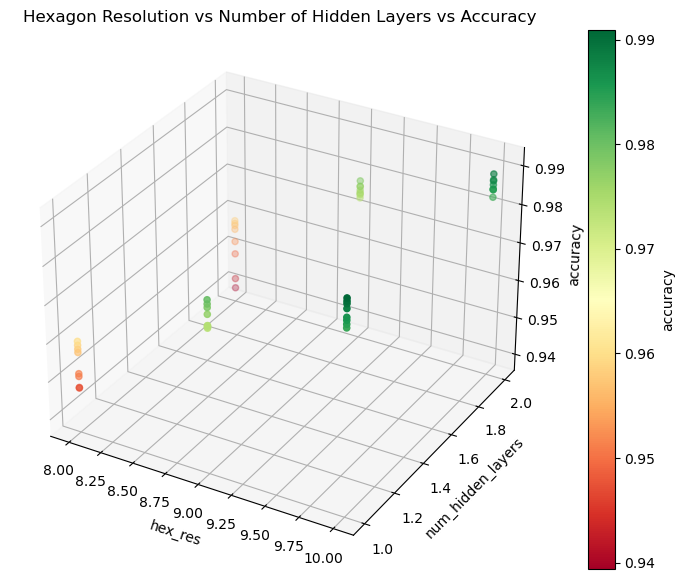

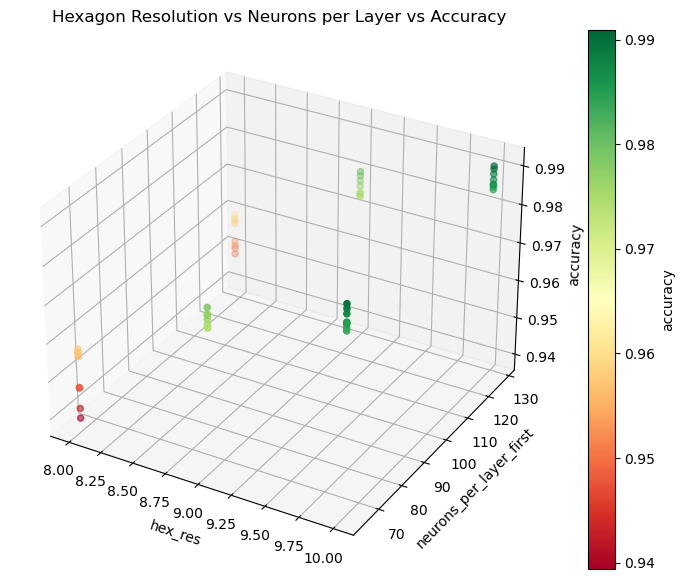

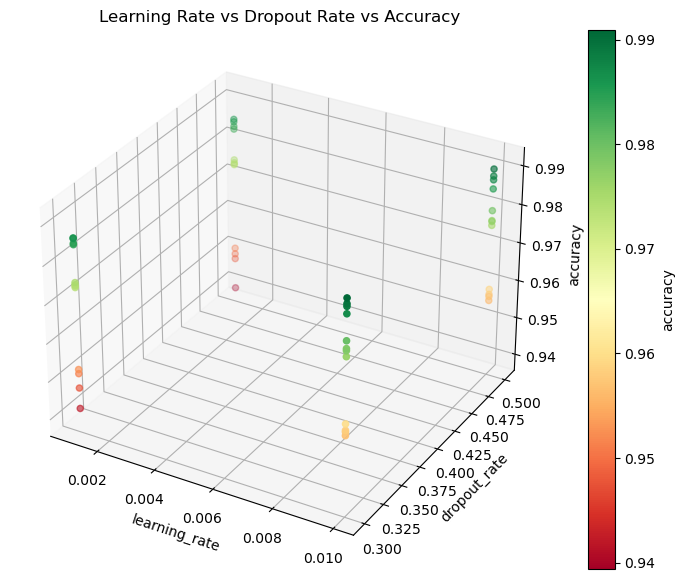

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Laad de resultaten van de CSV
results_df = pd.read_csv('model_optimization_results.csv')

def plot_3d(df, x_param, y_param, z_param, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    x = df[x_param]
    y = df[y_param]
    z = df[z_param]

    # Scatter plot met kleurenschema van rood naar groen
    scatter = ax.scatter(x, y, z, c=z, cmap='RdYlGn', marker='o')
    fig.colorbar(scatter, ax=ax, label=z_param)
    
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)
    ax.set_zlabel(z_param)
    ax.set_title(title)
    plt.show()

# 1. Hexagon Resolution vs. Number of Hidden Layers vs. Accuracy
plot_3d(results_df, 'hex_res', 'num_hidden_layers', 'accuracy', 
        'Hexagon Resolution vs Number of Hidden Layers vs Accuracy')

# 2. Hexagon Resolution vs Neurons per Layer vs Accuracy
# Voor eenvoud nemen we de eerste waarde van neurons_per_layer lijst als vertegenwoordiger
results_df['neurons_per_layer_first'] = results_df['neurons_per_layer'].apply(lambda x: int(x.strip("[]").split(",")[0]))
plot_3d(results_df, 'hex_res', 'neurons_per_layer_first', 'accuracy', 
        'Hexagon Resolution vs Neurons per Layer vs Accuracy')

# 3. Learning Rate vs Dropout Rate vs Accuracy
plot_3d(results_df, 'learning_rate', 'dropout_rate', 'accuracy', 
        'Learning Rate vs Dropout Rate vs Accuracy')

#### Conclusions

##### SHAP (SHapley Additive exPlanations)

In [42]:
import shap

# Definieer de aanbevolen parameterinstellingen
hex_res = 10
num_hidden_layers = 2
neurons_per_layer = [128, 64]
dropout_rate = 0.3
learning_rate = 0.001
epochs = 10
batch_size = 128

# Train het model en bewaar het getrainde model en input tensors
def train_and_get_shap_values():
    # Train het model met de aanbevolen parameters
    accuracy, loss, model, X_train_tensor, X_test_tensor = train_evaluate_model(
        hex_res=hex_res,
        num_hidden_layers=num_hidden_layers,
        neurons_per_layer=neurons_per_layer,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        epochs=epochs,
        batch_size=batch_size,
        return_model=True  # Zorg dat de functie het model en de tensors teruggeeft
    )
    
    # Bereken SHAP waarden voor het getrainde model
    explainer = shap.DeepExplainer(model, X_train_tensor)
    shap_values = explainer.shap_values(X_test_tensor)
    
    # Visualiseer SHAP waarden
    shap.summary_plot(shap_values, X_test_tensor, plot_type="bar")

# Functie aanroepen om het model te trainen en SHAP-analyse uit te voeren
train_and_get_shap_values()

ImportError: Numba needs NumPy 1.24 or less

## 3. Decision Trees / Random Forests

## 4. Support Vector Machines (SVM)

## 5. Gradient Boosting Machines (XGBoost, LightGBM)